In [1]:
import numpy as np
import pandas as pd
import rpy2

In [8]:
%matplotlib inline
import matplotlib as plt

In [2]:
# R magic using rpy2!
%load_ext rpy2.ipython

Simulata data from
$$Y_t = ct + \phi Y_{t-1} + \epsilon_t$$


with $c=0.2$, $\phi=0.9$ and $\epsilon_t$ being white noise.

https://stats.stackexchange.com/questions/294600/how-can-i-simulate-with-arima-sim-drift-intercept-and-trend

In [41]:
%%R -o ar_sim
set.seed(5)
model = list(order=c(1,0,0),ar=c(.9))
n = 100
c = 0.02

ar_sim = as.data.frame(arima.sim(model=model, n=n))
ar_sim = ar_sim + c*seq(1,n)

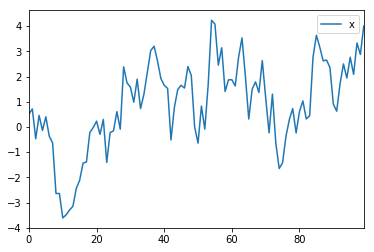

In [42]:
ar_sim.plot()